## Imports

In [1]:
import numpy as np
import torch
import torchvision
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import glob
import random
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Hyper-parameters

In [2]:
BATCH_SIZE =42
LR = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Dynamically assigns GPU or CPU usage

In [3]:
import glob
def get_paths(directory, label):
    paths = []
    for filename in glob.glob(os.path.join(directory, '*.jpg')):
        paths.append([filename,label])
    return paths

In [4]:
resume_data_test_paths = ['/kaggle/input/resume-dataset/123.v4i.multiclass/test','/kaggle/input/resume-dataset/Resume Parser2.v1-without-data-aug-prepro.multiclass/test']
resume_data_train_paths = ['/kaggle/input/resume-dataset/Resume Parser2.v1-without-data-aug-prepro.multiclass/train','/kaggle/input/resume-dataset/123.v4i.multiclass/train']

non_resume_data_paths = ['/kaggle/input/webscreenshots/screenshots-224x224/screenshots-224x224/machinery',
                         '/kaggle/input/webscreenshots/screenshots-224x224/screenshots-224x224/music',
                         '/kaggle/input/webscreenshots/screenshots-224x224/screenshots-224x224/sport',
                         '/kaggle/input/webscreenshots/screenshots-224x224/screenshots-224x224/tourism']

## Filepath Handling

In [5]:
ResumePaths = []
train_paths = []
test_paths = []


for path in resume_data_test_paths:
    ResumePaths += get_paths(path,1.0)

for path in resume_data_train_paths:
    ResumePaths += get_paths(path,1.0)
    
ms = int(0.8*len(ResumePaths))
train_paths+= ResumePaths[0:ms]
test_paths+= ResumePaths[ms:]
nr_paths = []
for path in non_resume_data_paths:
    nr_paths =  get_paths(path,0.0)
    train_paths += nr_paths[0:508]
    test_paths += nr_paths[508:508+127]
    

## Creating The Dataset

In [6]:
test_df = pd.DataFrame(test_paths, columns=['path', 'label'])
train_df = pd.DataFrame(train_paths, columns=['path', 'label'])

In [7]:
class MyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['path'][idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor([self.df['label'][idx]], dtype = torch.float32)




## Specifying Transforms

In [8]:
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    
    transforms.RandomChoice([
        transforms.ColorJitter(),
        transforms.RandomAdjustSharpness(0.1),
        transforms.CenterCrop(256),
    ]),
    transforms.ToTensor()
])


#### Dataloader


In [9]:
train_dataset = MyDataset(train_df, transform = train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)

test_dataset = MyDataset(test_df, transform = test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)


## Creating the Model

In [10]:
class Binary_Classifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.EN = models.resnet152(pretrained = True) # Pretrained Model 
        
        self.fc = nn.Sequential( # Converging the 100 sized vector into a probability distribution
            nn.Linear(1000, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.EN(x)
        x = self.fc(x)
        return x

In [11]:
model = Binary_Classifier()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 227MB/s]


In [12]:
model.to(device)

Binary_Classifier(
  (EN): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [14]:
model.train()
epoch_losses = []
for epoch in range(5):
    epoch_loss = 0
    for batch_idx, (data, target) in tqdm(enumerate(train_dataloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss = loss.to(device)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(train_dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch}, Epoch loss {epoch_loss}")
    


97it [02:53,  1.79s/it]


Epoch 0, Epoch loss 0.04883029777924206


97it [02:21,  1.46s/it]


Epoch 1, Epoch loss 0.013483648271860672


97it [02:22,  1.46s/it]


Epoch 2, Epoch loss 0.003619560407444333


97it [02:22,  1.47s/it]


Epoch 3, Epoch loss 0.0014488573598081876


97it [02:21,  1.46s/it]

Epoch 4, Epoch loss 0.0164246305772235


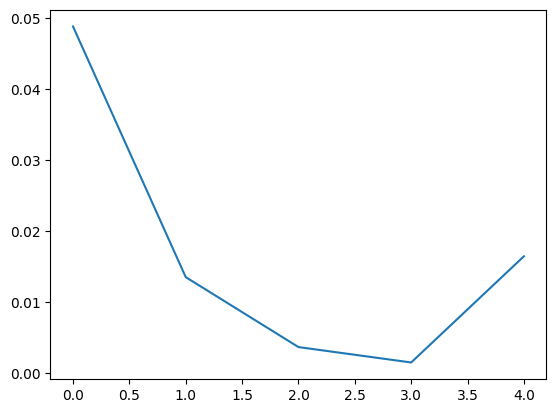

In [15]:
plt.plot(epoch_losses)

In [16]:
y_true = []
y_pred = []
model.eval()
for epoch in range(1):
    for batch_idx, (data, target) in tqdm(enumerate(DataLoader(test_dataset, batch_size=1, shuffle = True))):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        y_true.append(target.item())
        
        if output.item() > 0.5:
            op = 1.0
        else:
            op = 0.0
        y_pred.append(op)

1016it [00:38, 26.23it/s]


In [17]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[500,   8],
       [  4, 504]])

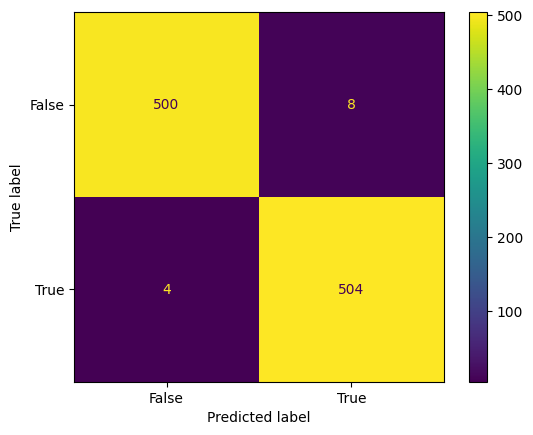

In [18]:

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()


In [19]:
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]


In [20]:
print(f"True Negatives:{TN}, True Positives:{TP}, False Negatives:{FN}, False Positives:{FP}")

True Negatives:500, True Positives:504, False Negatives:4, False Positives:8


In [21]:
Accuracy = (TP+TN)/ (TP+TN+FP+FN)
print(Accuracy)

0.9881889763779528


In [22]:
Recall = TP/ (TP+FN)
print(Recall)

0.9921259842519685


In [23]:
Precision = TP/ (TP+FP)
print(Precision)

0.984375


In [24]:
F1 = 2*Precision*Recall/(Precision+Recall)
print(F1)

0.988235294117647
